In [96]:
import json
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
from collections.abc import Iterable


plt.rcParams.update({
    "figure.figsize": (4 * 0.7, 3 * 0.7),
    "figure.dpi": 300,
    "figure.autolayout": False,
    "text.usetex": True,
    'mathtext.fontset': 'stix',
    'font.family': 'STIXGeneral',
    'savefig.transparent': False,
})


def load_json(filepath):
    with open(filepath) as file:
        return json.load(file)


def plot_results(dataset, model, methods, x_axis, y_axis, k, seeds, x_axis_label, y_axis_label, title):
    texts = []
    x_rep = []
    y_rep = []
    e = f"{dataset}_{model}"
    e = dataset

    fig = plt.figure()

    #fig.patch.set_facecolor('red')
    fig.patch.set_alpha(0)

    plt.clf()
    ax = plt.gca()
    ax.set_facecolor('white')

    for n, v in methods.items():
        # if len(v) == 1:
        #     path = f"results/{e}/{v.keys()[0]}_k={k}_s={seed}_results.json"
        #     method = load_json(path)
        #     plt.scatter(method[x_axis], method[y_axis], label=v.values()[0])
        #     plt.annotate(l, (method[x_axis], method[y_axis]))
        # else:
        x_vals = []
        y_vals = []
        x_errors = []
        y_errors = []
        for m, l in v.items():
            #path = f"../results/{e}{m}_k={k}_s={seed}_t=0.0_r=0.0_results.json"
            if isinstance(seeds, Iterable):
                y = []
                x = []
                for seed in seeds:
                    path = f"../results_bca/{e}{m}_k={k}_s={seed}_results.json"
                    method = load_json(path)
                    x.append(method[x_axis])
                    y.append(method[y_axis])
            else:
                path = f"../results_bca/{e}{m}_k={k}_s={seeds}_results.json"
                method = load_json(path)
                x = method[x_axis] * 100
                y = method[y_axis] * 100

            x_error = 0
            y_error = 0

            if isinstance(x, list):
                x = np.array(x) * 100
                x_error = np.std(x)
                x = np.mean(x)
            
            if isinstance(y, list):
                y = np.array(y) * 100
                y_error = np.std(y)
                y = np.mean(y)

            x_vals.append(x)
            y_vals.append(y)
            x_errors.append(x_error)
            y_errors.append(y_error)
            # plt.annotate(l, (x_val[-1] + 0.002, y_val[-1] + 0.004), 
            #              horizontalalignment='left',
            #              verticalalignment='bottom',
            #              clip_on=False)
            if l is not None:
                texts.append(plt.text(x_vals[-1], y_vals[-1], l, size=10))
                #texts.append(plt.text(x_val[-1] + 0.002, y_val[-1] + 0.004, l, size=7))
                x_rep.append(x_vals[-1])
                y_rep.append(y_vals[-1])
        #print(x_vals, y_vals, x_errors, y_errors)
        plt.plot(x_vals, y_vals, '.', linestyle="-")
        #plt.errorbar(x_vals, y_vals, xerr=x_errors, yerr=y_errors, fmt='.', linestyle="-", linewidth=1, capsize=2, capthick=1)

    adjust_text(texts, x_rep, y_rep, 
                min_arrow_len=50,
                # force_text=(0.3, 0.6),
                # force_static=(0.3, 0.6),
                # force_explode=(0.3, 0.6),
                # expand=(1.4, 1.6),
                time_lim=1, 
                #explode_radius=200, 
                #expand_axes=True,
                #only_move = {"text": "y", "static": "y", "explode": "y", "pull": "y"},
                arrowprops={"arrowstyle": "->", "lw": 0.5},
                force_text=(0.1, 0.5),# Since the movements are so contrained, high force speeds up the process a lot
                expand=(1.5, 1.5),
                only_move='y-', #Only allow movement to the left
                )
    #plt.legend()

    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    # plt.ylim([0, 1])
    # plt.xlim([0, 1])
    #plt.title(f"{dataset.capitalize()}")
    plt.title(title)
    plt.margins(0.15, 0.25)
    
    #plt.plot()
    plt.savefig(f"plots/{e}_mixed_{x_axis}_{y_axis}_k={k}.png", dpi=300, bbox_inches='tight')

model = "lightxml"
k = 3

# ETU

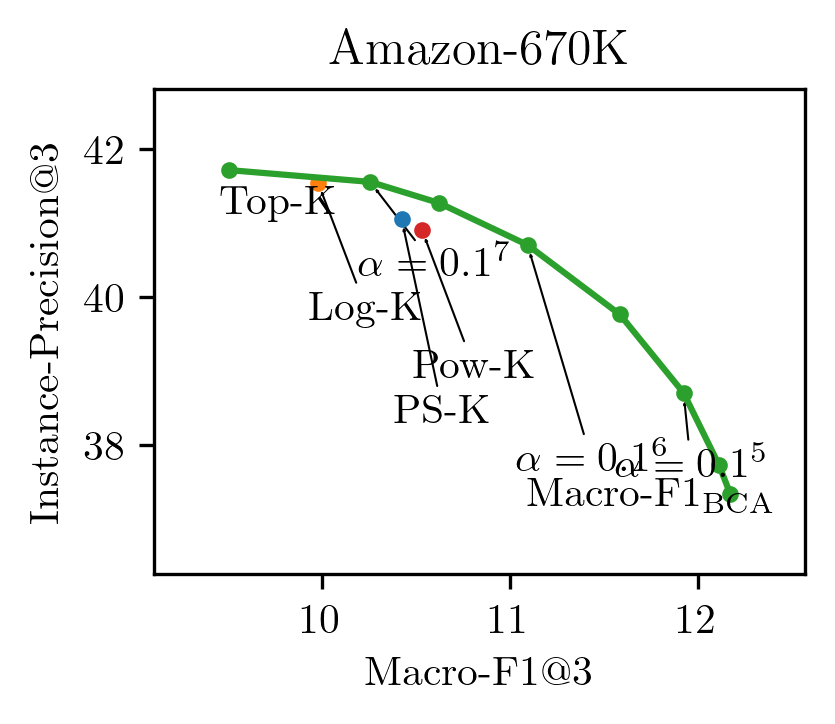

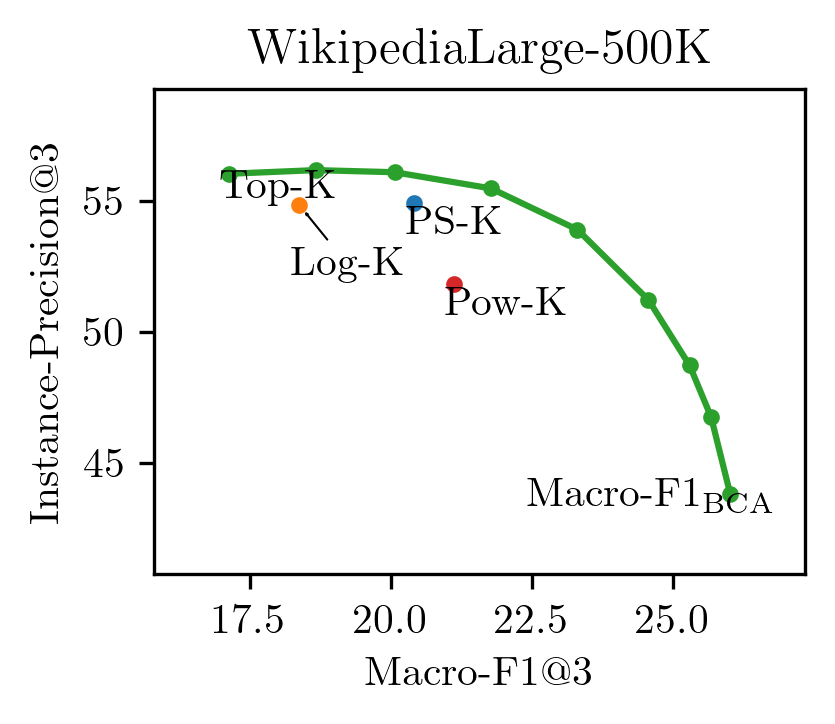

In [97]:
dataset_names = {
    "eurlex": "Eurlex-4K",
    "amazoncat": "AmazonCat-13K",
    "wiki10": "Wiki10-31K",
    "amazon_1000": "Amazon-670K",
    "wiki500_1000": "WikipediaLarge-500K",
}

macro_type = "f1"
x_axis = f"m{macro_type[0].upper()}@{k}"
y_axis = f"iP@{k}"
macro_type_label = macro_type[0].upper()
if macro_type == "f1":
    macro_type_label = macro_type.upper()
x_axis_label = f"Macro-{macro_type_label}@{k}"
y_axis_label = f"Instance-Precision@{k}"

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-macro-{macro_type}-tol=1e-7": f"Macro-{macro_type_label}" + "$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999999-tol=1e-7": "$\\alpha=0.1^{6}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999999-tol=1e-7": "$\\alpha=0.1^{7}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K"},
}

d = "amazon_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13, 26, 42, 1993, 2023], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-macro-{macro_type}-tol=1e-7": f"Macro-{macro_type_label}" + "$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999999-tol=1e-7": "$\\alpha=0.1^{6}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999999-tol=1e-7": "$\\alpha=0.1^{7}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K"},
}

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-macro-{macro_type}-tol=1e-7": f"Macro-{macro_type_label}" + "$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999999-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999996837-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999999-tol=1e-7": None,
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K"},
}

d = "wiki500_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13, 26, 42, 1993, 2023], x_axis_label, y_axis_label, title)
plt.show()

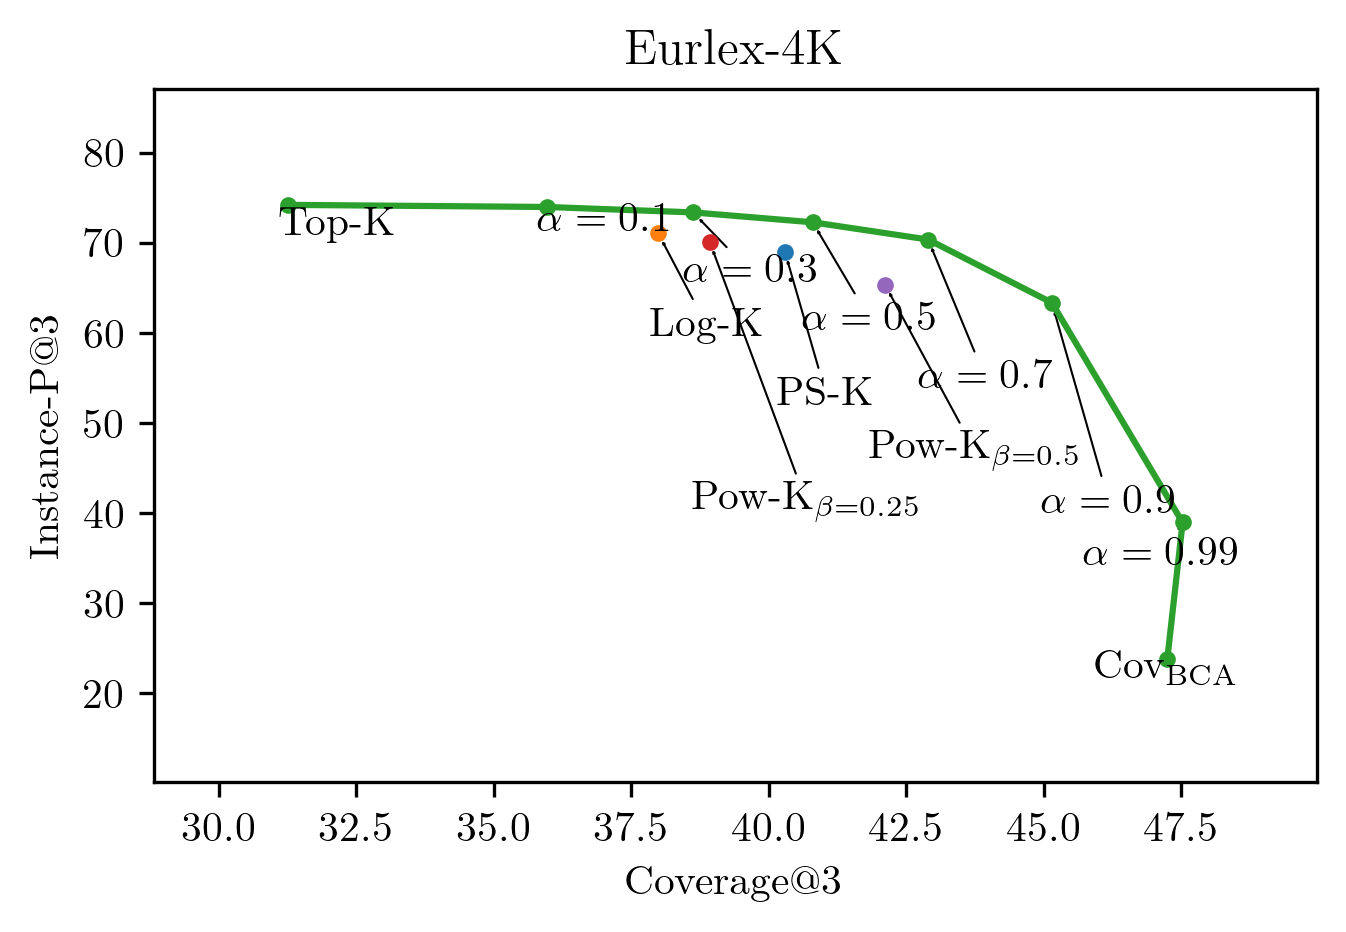

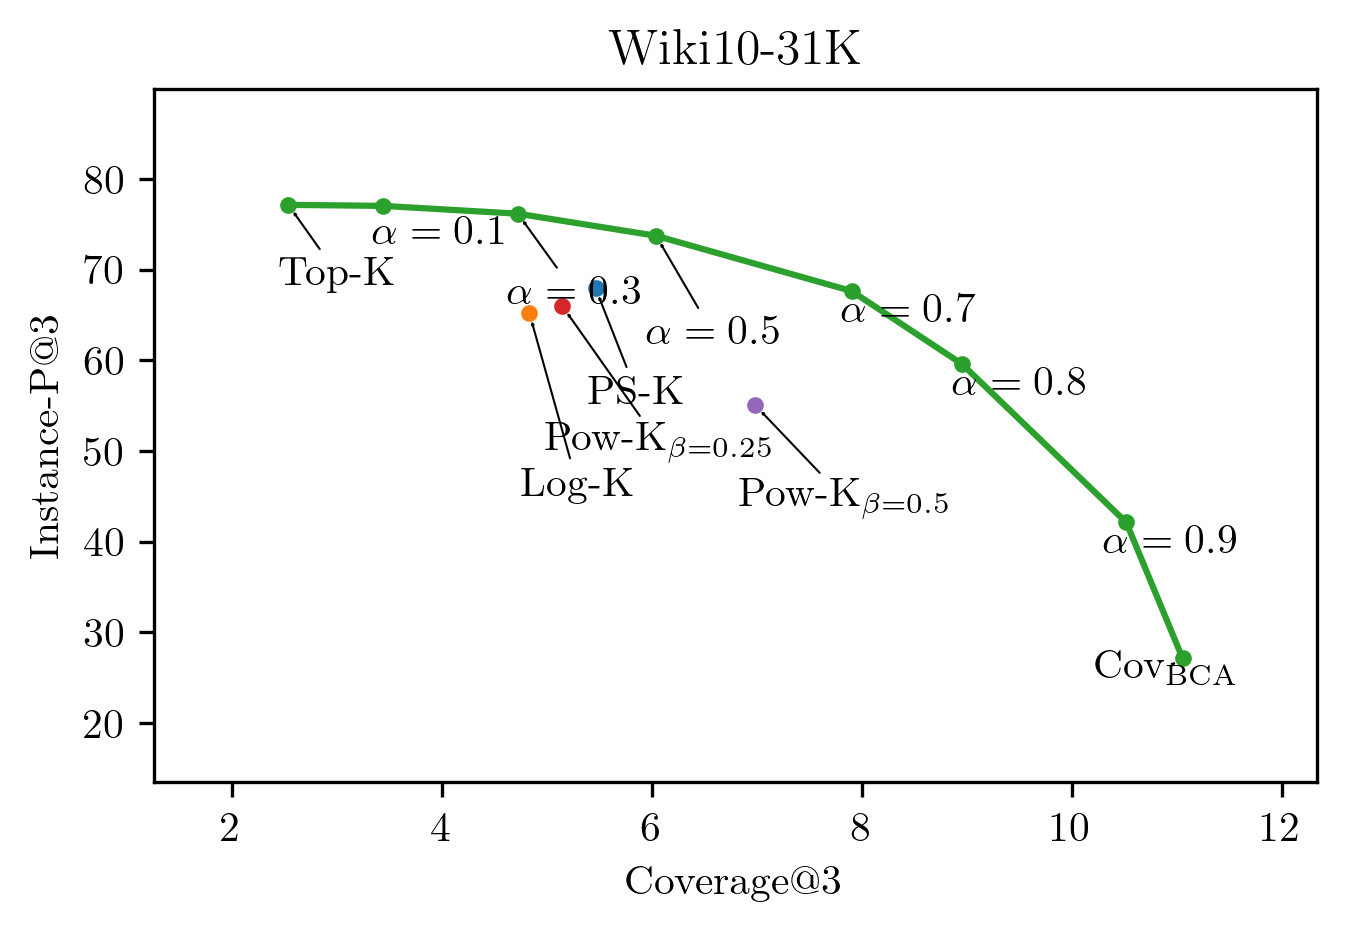

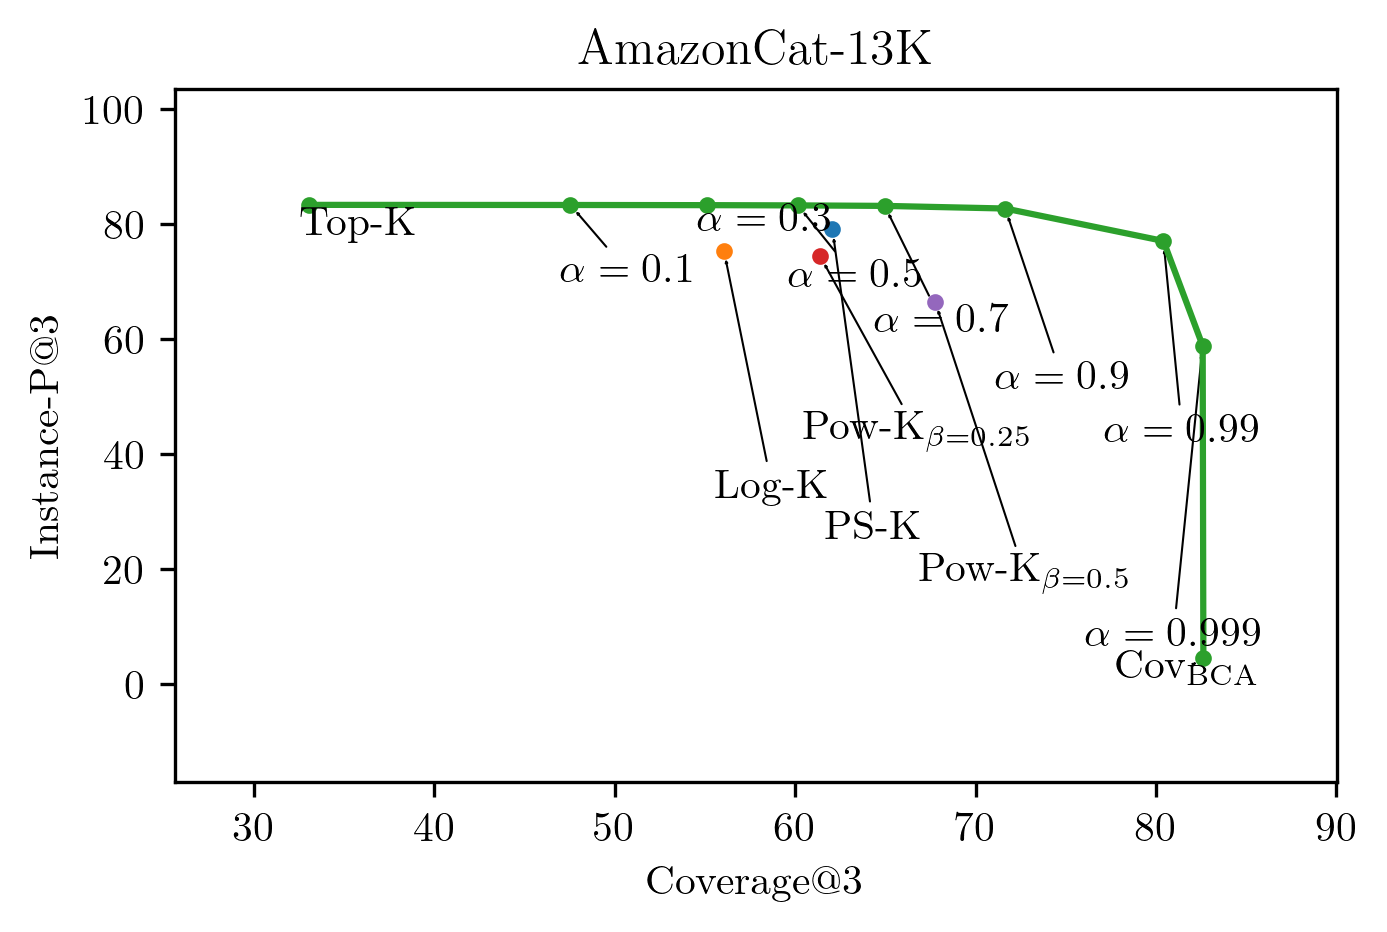

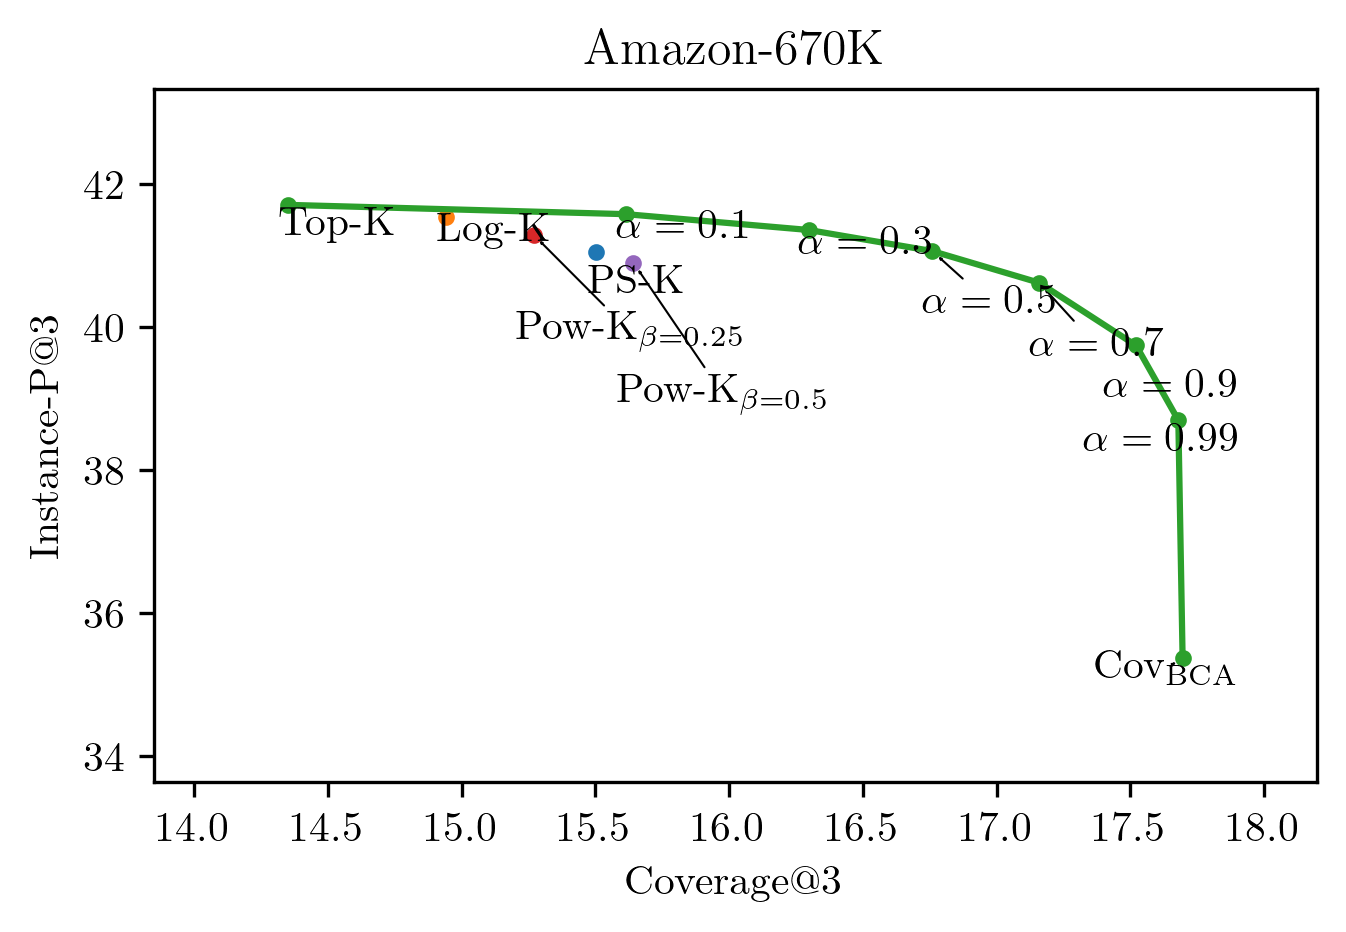

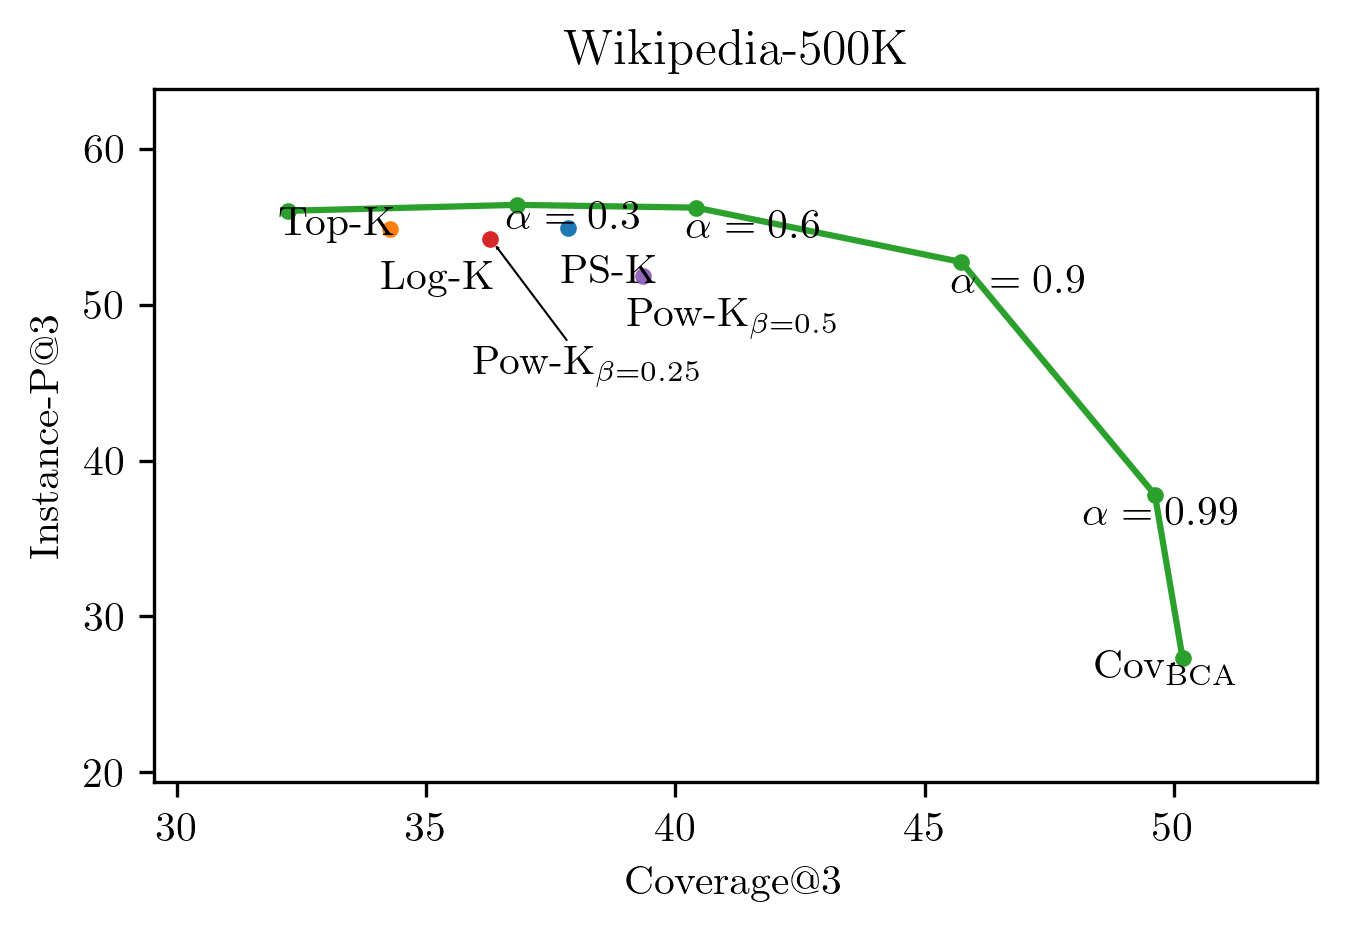

In [26]:
dataset_names = {
    "eurlex": "Eurlex-4K",
    "amazoncat": "AmazonCat-13K",
    "wiki10": "Wiki10-31K",
    "amazon_1000": "Amazon-670K",
    "wiki500_1000": "Wikipedia-500K",
}

macro_type = "cov"
x_axis = f"m{macro_type[0].upper()}@{k}"
y_axis = f"iP@{k}"
x_axis_label = f"Coverage@{k}"
y_axis_label = f"Instance-P@{k}"


methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": "$\\alpha=0.95$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": "$\\alpha=0.8$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": "$\\alpha=0.7$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": "$\\alpha=0.5$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": "$\\alpha=0.4$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": "$\\alpha=0.2$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": "$\\alpha=0.1$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "eurlex"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": "$\\alpha=0.95$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": "$\\alpha=0.8$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": "$\\alpha=0.7$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": "$\\alpha=0.5$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": "$\\alpha=0.4$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": "$\\alpha=0.2$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": "$\\alpha=0.1$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "wiki10"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": "$\\alpha=0.95$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": "$\\alpha=0.8$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": "$\\alpha=0.7$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": "$\\alpha=0.5$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": "$\\alpha=0.4$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": "$\\alpha=0.2$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": "$\\alpha=0.1$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "amazoncat"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": "$\\alpha=0.95$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": "$\\alpha=0.8$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": "$\\alpha=0.7$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": "$\\alpha=0.5$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": "$\\alpha=0.4$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": "$\\alpha=0.2$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": "$\\alpha=0.1$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "amazon_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": "$\\alpha=0.95$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": "$\\alpha=0.8$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": "$\\alpha=0.7$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": "$\\alpha=0.5$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": "$\\alpha=0.4$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": "$\\alpha=0.2$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": "$\\alpha=0.1$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "wiki500_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

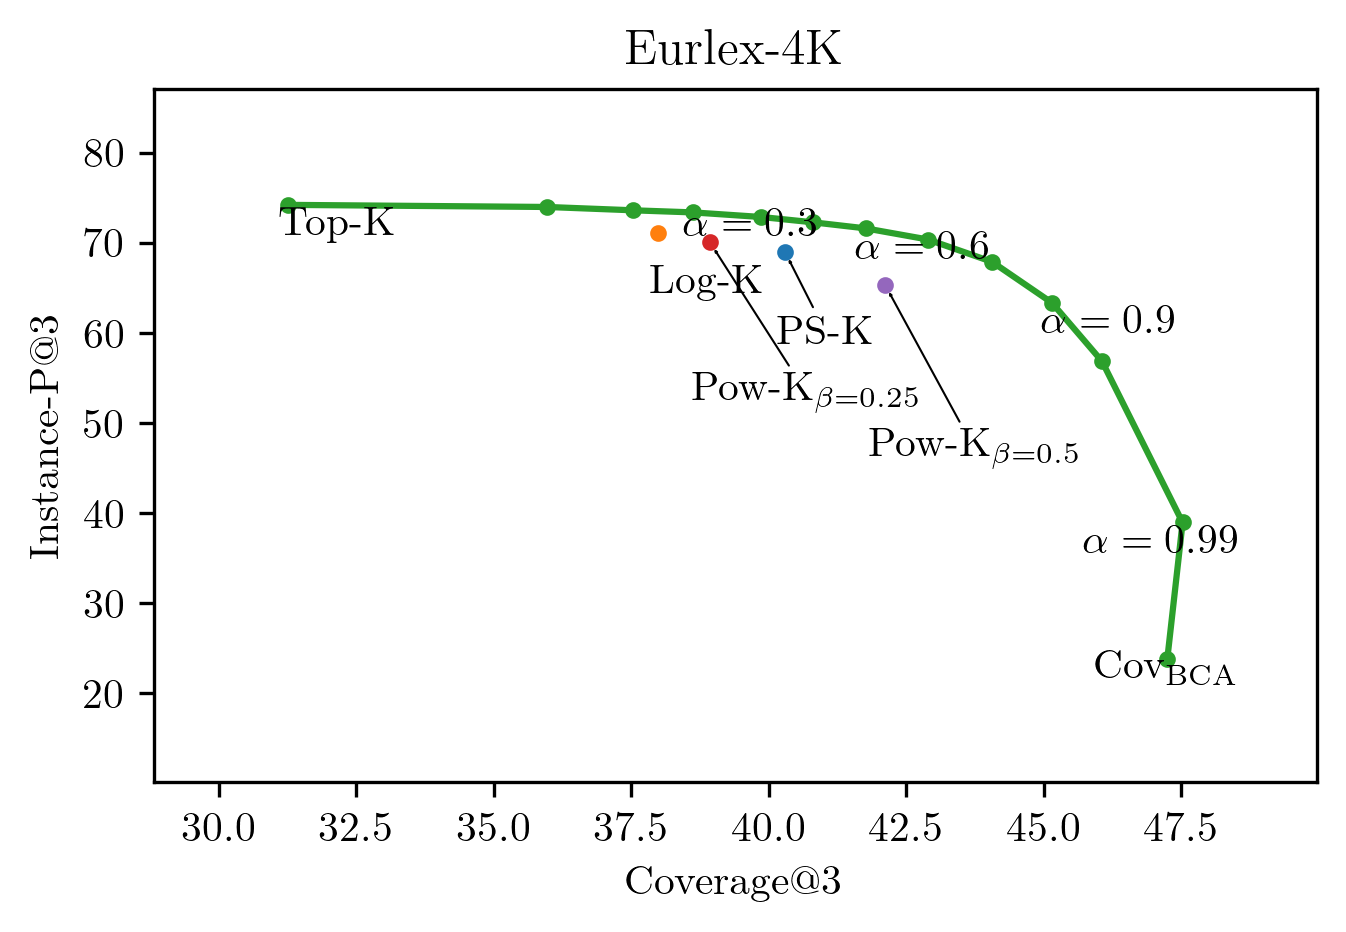

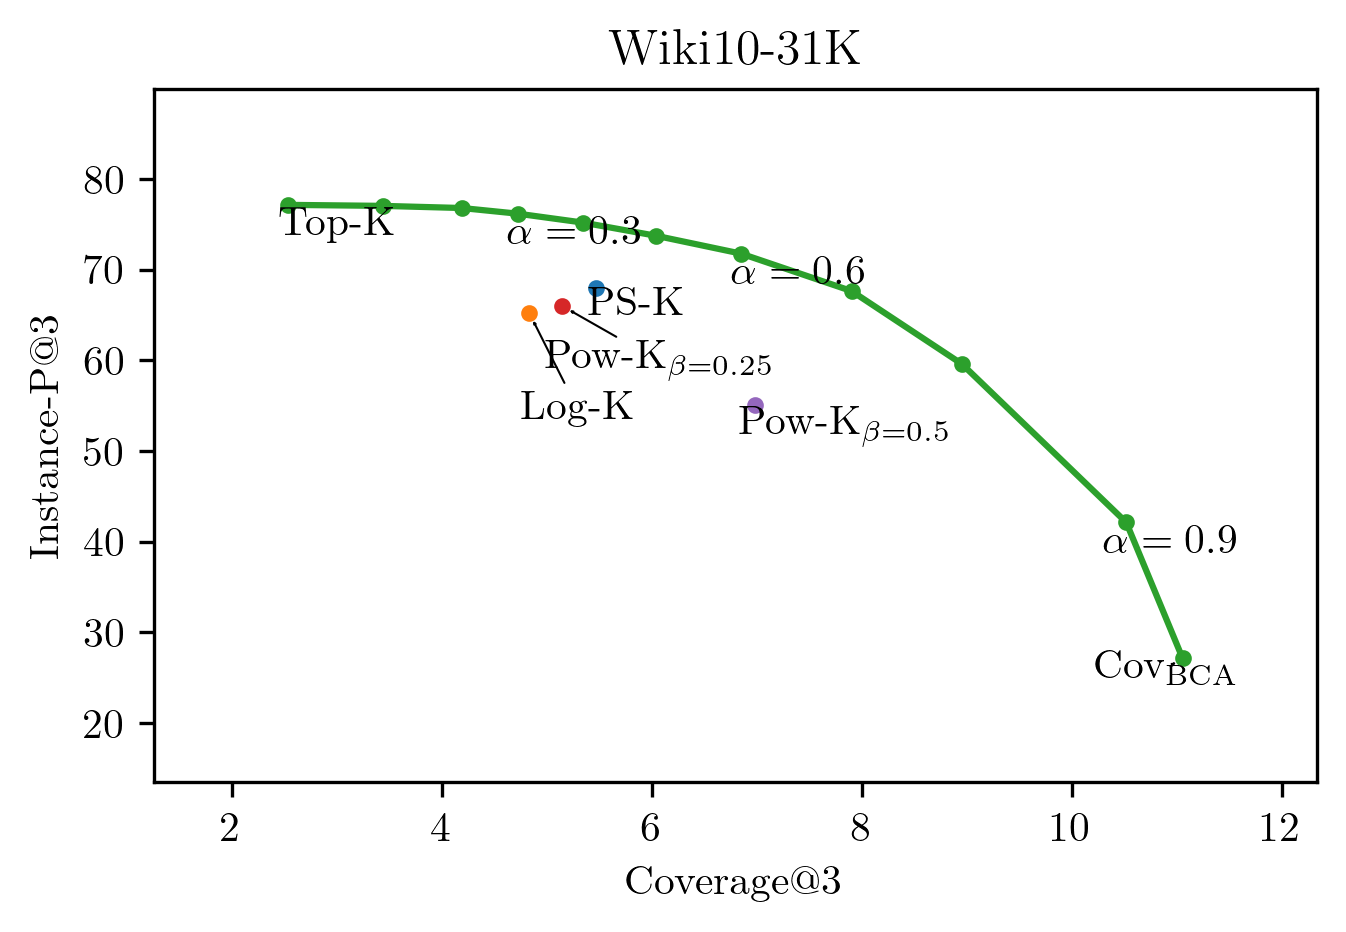

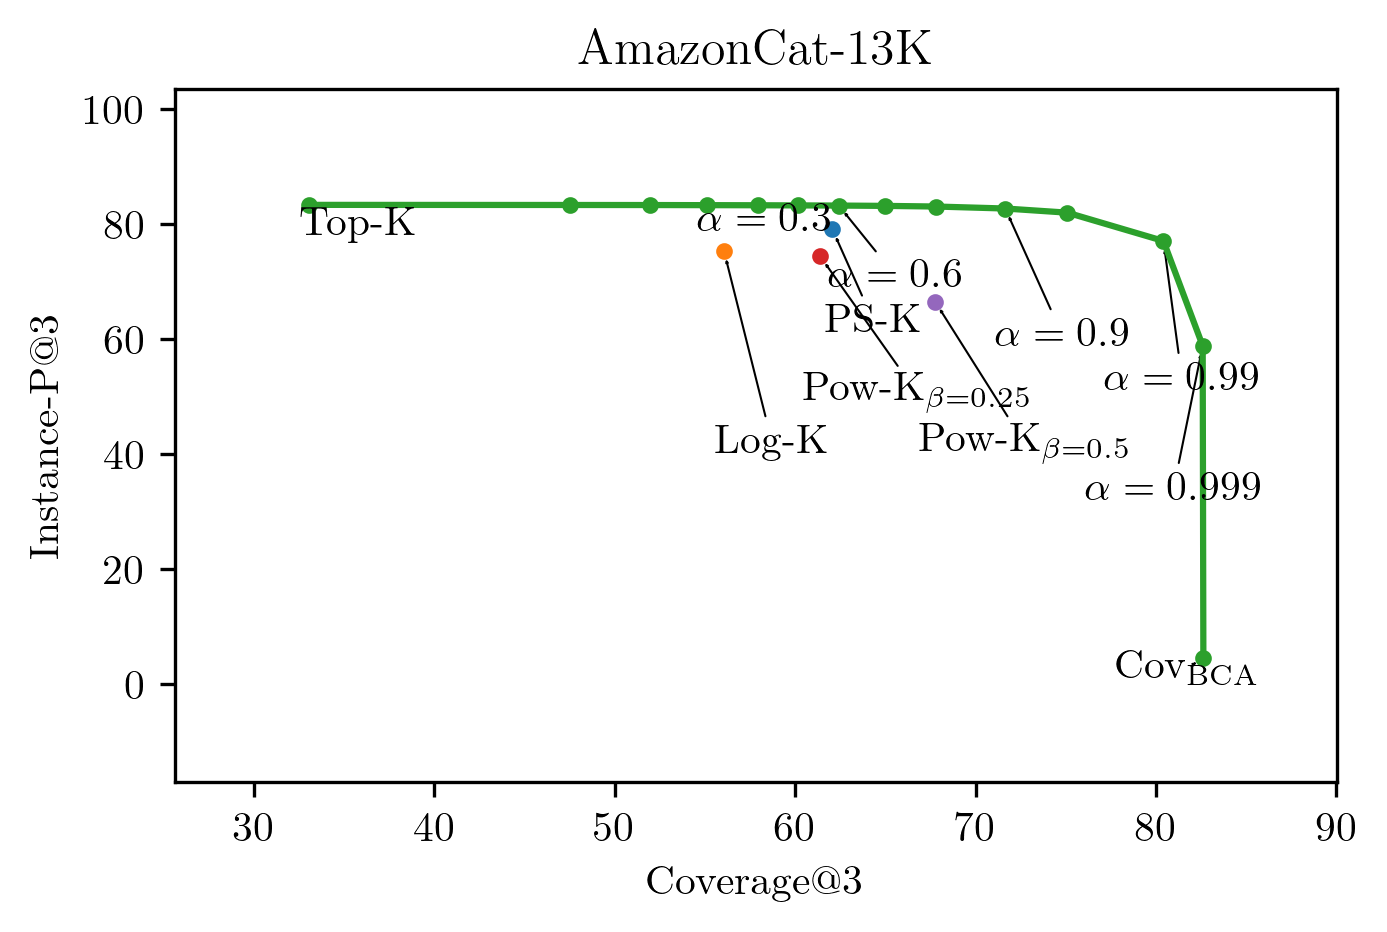

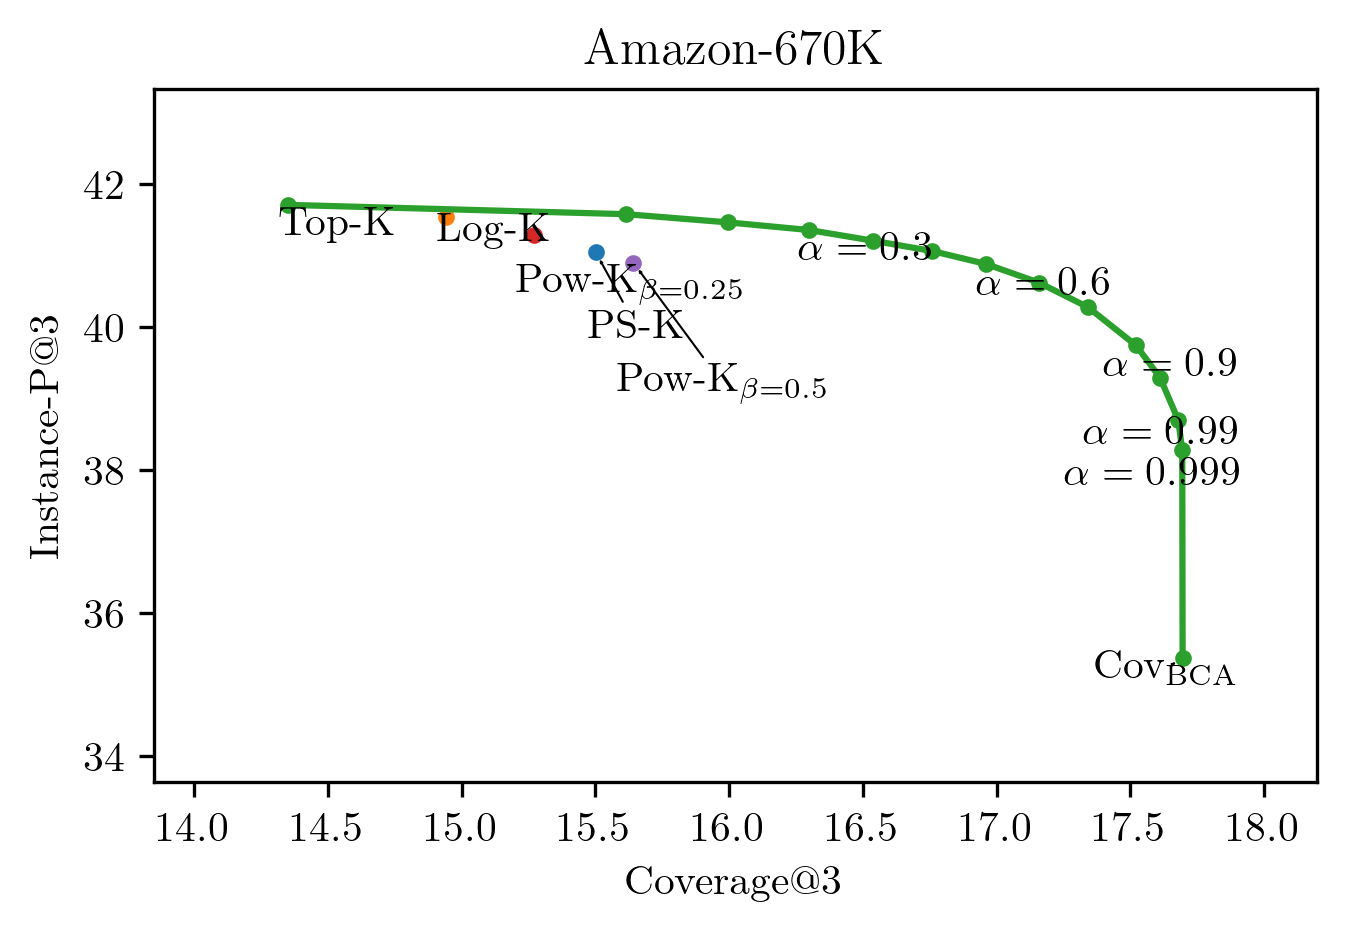

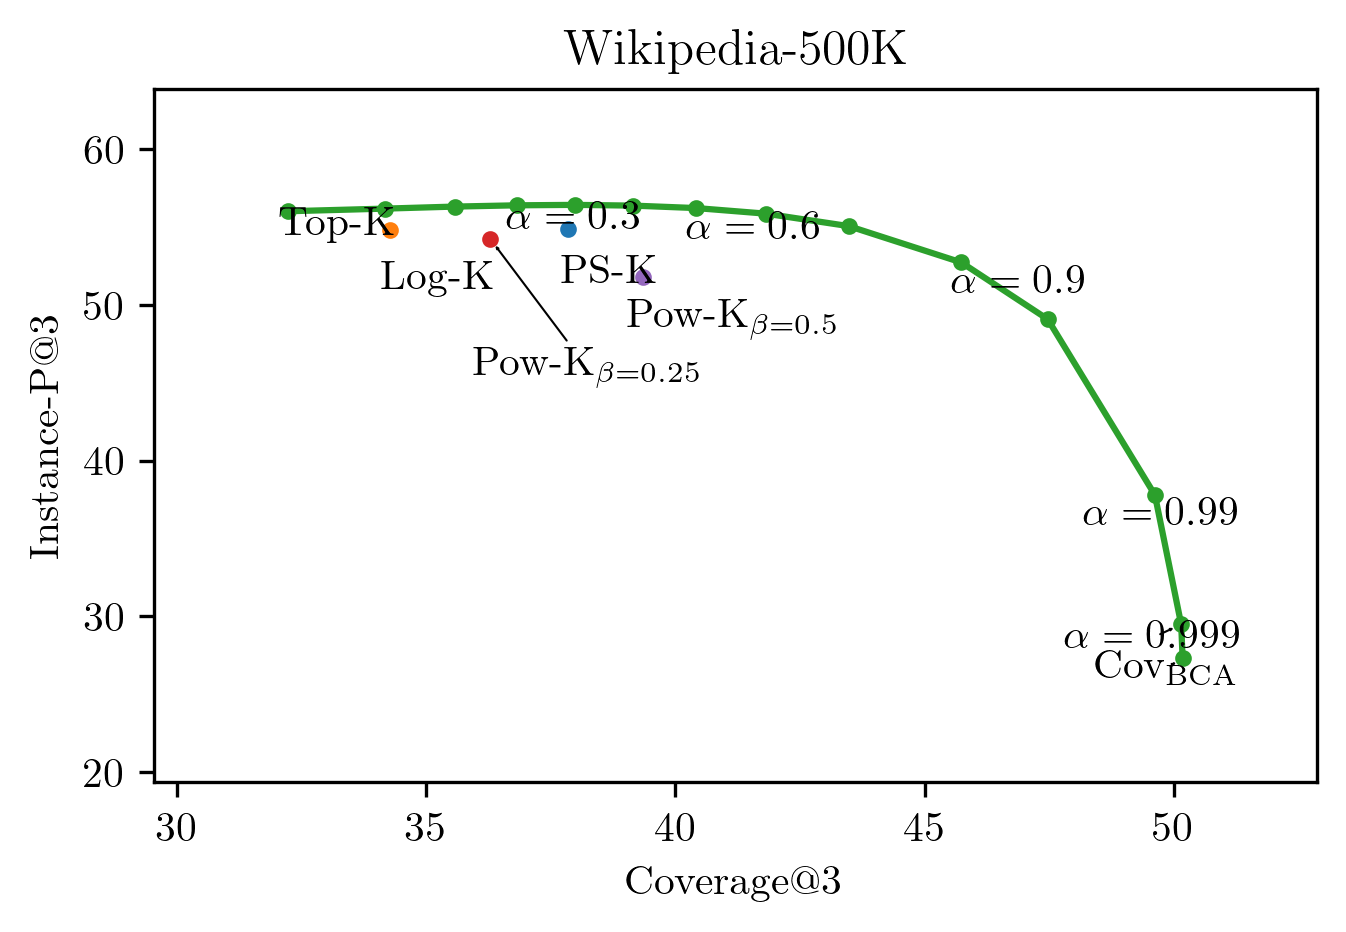

In [27]:
dataset_names = {
    "eurlex": "Eurlex-4K",
    "amazoncat": "AmazonCat-13K",
    "wiki10": "Wiki10-31K",
    "amazon_1000": "Amazon-670K",
    "wiki500_1000": "Wikipedia-500K",
}

macro_type = "cov"
x_axis = f"m{macro_type[0].upper()}@{k}"
y_axis = f"iP@{k}"
x_axis_label = f"Coverage@{k}"
y_axis_label = f"Instance-P@{k}"


methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": None,
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "eurlex"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": None,
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}


d = "wiki10"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()


methods = {
    "ps-k": {"_lightxml/optimal-instance-ps-prec": "PS-K"},
    "log": {"_lightxml/log": "Log-K"},
    "mixed-tol=7": {
        f"_lightxml/block-coord-{macro_type}-tol=1e-7": "Cov$_{\\mathrm{BCA}}$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.001-tol=1e-7": "$\\alpha=0.999$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.01-tol=1e-7": "$\\alpha=0.99$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.05-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.1-tol=1e-7": "$\\alpha=0.9$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.2-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.3-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.4-tol=1e-7": "$\\alpha=0.6$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.5-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.6-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.7-tol=1e-7": "$\\alpha=0.3$",
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.8-tol=1e-7": None,
        f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9-tol=1e-7": None,
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99-tol=1e-7": "$\\alpha=0.1^{2}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.999-tol=1e-7": "$\\alpha=0.1^{3}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.9999-tol=1e-7": "$\\alpha=0.1^{4}$",
        #f"_lightxml/block-coord-mixed-prec-{macro_type}-alpha=0.99999-tol=1e-7": "$\\alpha=0.1^{5}$",
        f"_lightxml/optimal-instance-prec": "Top-K",
    },
    "pow-beta=0.25": {"_lightxml/power-law-with-beta=0.25": "Pow-K$_{\\beta=0.25}$"},
    "pow-beta=0.5": {"_lightxml/power-law-with-beta=0.5": "Pow-K$_{\\beta=0.5}$"},
}

d = "amazoncat"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()


d = "amazon_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()

d = "wiki500_1000"
title = dataset_names[d]
plot_results(d, model, methods, x_axis, y_axis, k, [13], x_axis_label, y_axis_label, title)
plt.show()